# Analyse biochemical properties of isopeptide bond PDB/AF2 datasets

In [1]:
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
import seaborn as sns
import matplotlib.pyplot as plt
from biotite.structure.io import pdb
import biotite.structure as struc
import shutil
import sys
sys.path.append("../bin")
from sequence import get_sequence

In [2]:
load_dotenv("../.env")
PDB_BIOCHEM = os.getenv("PDB_BIOCHEM")
AF2_BIOCHEM = os.getenv("AF2_BIOCHEM")
AF2_TEMPLATES_BIOCHEM = os.getenv("AF2_TEMPLATES_BIOCHEM")
TABLE = os.getenv("TABLE")

In [3]:
pdb_df = pd.read_csv(PDB_BIOCHEM)
af_df = pd.read_csv(AF2_BIOCHEM)
af_templates_df = pd.read_csv(AF2_TEMPLATES_BIOCHEM)
table_df = pd.read_csv(TABLE)

# Get isopep sequence (between bonded residues)
pdb_df["isopep_sequence"] = pdb_df.apply(get_sequence, pdb=True, axis=1)
af_df["isopep_sequence"] = af_df.apply(get_sequence, pdb=False, axis=1)
af_templates_df["isopep_sequence"] = af_templates_df.apply(get_sequence, pdb=False, axis=1)

# Add cis info
pdb_df["cis"] = False
pdb_df.loc[(pdb_df["pseudo_omega"]>=-60)&(pdb_df["pseudo_omega"]<=60), "cis"] = True

## Pfam domain mapping

In [16]:
import sys
sys.path.append("../bin")
from pfamenv import PFAM_HOST,PFAM_PASSWORD,PFAM_PORT,PFAM_USER,PFAM_VERSION
from mysql import connector
import numpy as np

def is_domain(row):
    """

        Assign if at least 2/3 residues are in domain
    
    """
    residues = [row["r1_bond"], row["r_cat"], row["r2_bond"]]
    status = False
    c = 0
    for res in residues:
        if res >= row["seq_start"] and res <= row["seq_end"]:
            c += 1
            #status = True
            #break
    if c >= 2:
        status = True
    return status

In [17]:
# Get pfam info associated with each PDB
columns = ["pdb_id", "pfamA_acc", "pfamA_id", "chain", "pdb_res_start", "pdb_res_end", "seq_start", "seq_end", "clan_acc", "clan_id"]

proteins = pdb_df[(pdb_df["Is bonded"])&(~pdb_df["Interchain"])&(pdb_df["Isopeptide type"]!="Mutant")]["PDB code"].unique()

cnx = connector.connect(user=PFAM_USER,
                        password=PFAM_PASSWORD,
                        port=PFAM_PORT,
                        host=PFAM_HOST)
cursor = cnx.cursor()

proteins_ = ", ".join([f"'{protein}'" for protein in proteins])

# Get domains
cursor.execute(f"SELECT pdb_id,pfamA.pfamA_acc,pfamA.pfamA_id,chain,pdb_res_start,pdb_res_end,seq_start,seq_end,\
                    clan_membership.clan_acc,clan.clan_id \
                 FROM {PFAM_VERSION}.pdb_pfamA_reg, {PFAM_VERSION}.pfamA, \
                     {PFAM_VERSION}.clan_membership, {PFAM_VERSION}.clan \
                 WHERE pdb_id IN ({proteins_}) \
                 AND pfamA.pfamA_acc = clan_membership.pfamA_acc \
                 AND clan.clan_acc=clan_membership.clan_acc \
                 AND pfamA.pfamA_acc = pdb_pfamA_reg.pfamA_acc")
output = cursor.fetchall()
d_df = pd.DataFrame(output, columns = columns)
d_df["pdb_id"] = d_df["pdb_id"].apply(lambda x: x.lower())
data_df = pd.merge(pdb_df, d_df.rename(columns={"pdb_id":"PDB code", "chain":"Chain"}), how="left")\
        .rename(columns={"Position 1\r\n(Bond 1)":"r1_bond", "Position 2\r\n(catalytic)":"r_cat", "Position 3\r\n(Bond 2)":"r2_bond"})

# Check which domains map to isopep bonds
data_df["is_domain"] = data_df.apply(lambda x: is_domain(x), axis=1)
data_df = data_df.sort_values("is_domain", ascending=False) \
        .drop_duplicates(["PDB code", "r1_bond", "r_cat", "r2_bond"], keep="first")
data_df.loc[data_df["is_domain"]==False, "pfamA_acc"] = np.NaN
data_df.loc[data_df["is_domain"]==False, "pfamA_id"] = np.NaN
data_df.loc[data_df["is_domain"]==False, "seq_start"] = np.NaN
data_df.loc[data_df["is_domain"]==False, "seq_end"] = np.NaN
data_df["seq_start"] = data_df["seq_start"].fillna(0).astype(int)
data_df["seq_end"] = data_df["seq_end"].fillna(0).astype(int)
data_df["residues"] = data_df.apply(lambda x: ", ".join([str(_) for _ in [x["r1_bond"], x["r_cat"], x["r2_bond"]]]), axis=1)
data_df["PDB code"] = data_df["PDB code"].apply(lambda x: x.upper())

In [64]:
data_df[["pfamA_id", "pfamA_acc", "clan_id", "PDB code", "Chain", "seq_start", "seq_end", "residues"]]\
.drop_duplicates("pfamA_id").set_index("pfamA_id").sort_values("clan_id")

,pfamA_acc,clan_id,PDB code,Chain,seq_start,seq_end,residues
pfamA_id,,,,,,,
AgI_II_C2,PF17998,Adhesin,5DZ9,A,554,723,"556, 606, 703"
Sgo0707_N2,PF20623,Adhesin,4HSS,A,178,324,"187, 224, 299"
GramPos_pilinBB,PF16569,Adhesin,2X9Z,A,216,328,"193, 241, 318"
Collagen_bind,PF05737,Adhesin,7LGR,A,173,306,"177, 210, 291"
Antigen_C,PF16364,Adhesin,3OPU,A,1334,1492,"1334, 1383, 1469"
GBS104-like_Ig,PF21426,E-set,3TXA,A,587,717,"188, 597, 692"
DUF5979,PF19407,Transthyretin,4BUG,A,606,718,"610, 680, 715"
SpaA,PF17802,Transthyretin,2XID,A,291,377,"297, 347, 595"
GramPos_pilinD3,PF16570,Transthyretin,2X9Z,A,388,448,"349, 405, 428"


In [19]:
data_df["pfamA_id"].unique()

array(['DUF5979', 'AgI_II_C2', 'SpaA', 'Sgo0707_N2', 'GramPos_pilinBB',
       'GramPos_pilinD3', 'Collagen_bind', 'FctA', 'GramPos_pilinD1',
       'Antigen_C', 'GBS104-like_Ig', 'Cna_B', nan], dtype=object)

## Correlations

In [17]:
cond1 = (pdb_df["Is bonded"])
cond2 = (pdb_df["Isopeptide type"]!="Mutant")
cond3 = (~pdb_df["Unusual geometry/chemistry"])
cond4 = (pdb_df["Resolution"]<=2.5)
cond5 = (~pdb_df["Bad rotamer"])
cor_df = pdb_df[cond1&cond2&cond3&cond4&cond5].drop_duplicates("isopep_sequence").copy()

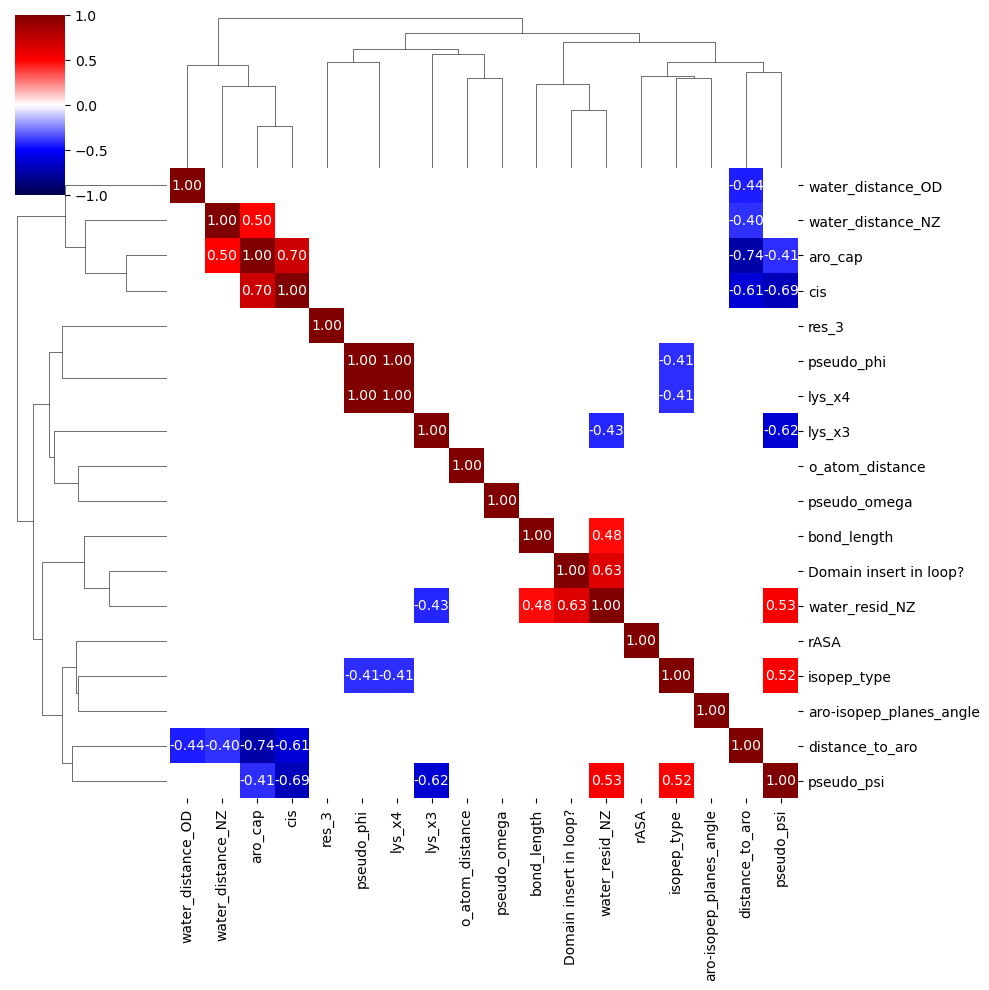

In [18]:
corr_matrix = cor_df[
    ['Isopeptide type', 'Domain insert in loop?',
       'distance_to_aro', 'aro-isopep_planes_angle', 'aro_cap',
       'water_resid_NZ', 'water_distance_NZ',
       'water_distance_OD', 'cis',
       'o_atom_distance', 'rASA', 'bond_length', 'pseudo_omega', 'pseudo_psi',
       'pseudo_phi', 'lys_x3', 'lys_x4', 'Residue 3']
    ].rename(columns={"Isopeptide type":"isopep_type", "Residue 3":"res_3"})\
    .assign(isopep_type=lambda x: x["isopep_type"].replace({"CnaA-like":0, "CnaB-like":1})) \
    .assign(res_3=lambda x: x["res_3"].replace({"N":1, "D":0})) \
    .assign(rASA=lambda x: x["rASA"].apply(lambda y: np.mean(eval(y)))) \
    .corr()

threshold = .4
mask = np.abs(corr_matrix) < threshold
sns.clustermap(corr_matrix, cmap="seismic", vmin=-1, vmax=1, annot=True, fmt=".2f", mask=mask)

## Aromatic residues

In [4]:
cond1 = (pdb_df["Is bonded"])
cond2 = (pdb_df["Isopeptide type"]!="Mutant")
cond3 = (~pdb_df["Unusual geometry/chemistry"])
cond4 = (pdb_df["Resolution"]<=2.5)
cond5 = (~pdb_df["Bad rotamer"])
aro_df = pdb_df[cond1&cond2&cond3&cond4&cond5].sort_values("aro_cap", ascending=False).drop_duplicates("isopep_sequence")

In [5]:
# 
aro_df.groupby("Isopeptide type")["aro_cap"] \
    .value_counts(normalize=True) \
    .mul(100) \
    .rename("percentage") \
    .reset_index().round()

,Isopeptide type,aro_cap,percentage
0,CnaA-like,True,71.0
1,CnaA-like,False,29.0
2,CnaB-like,False,59.0
3,CnaB-like,True,41.0


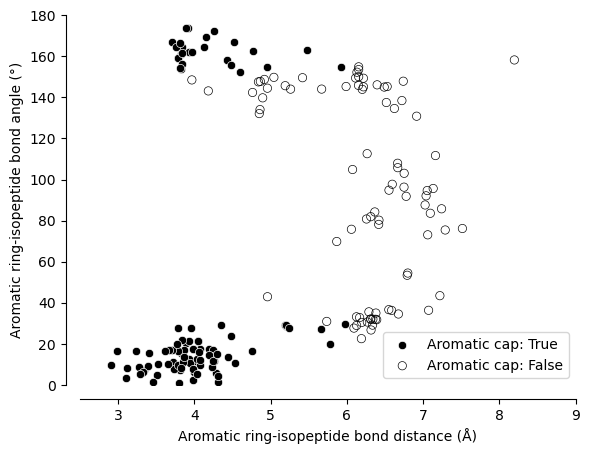

In [6]:
fig, ax = plt.subplots()

plot_df = pdb_df[pdb_df["Isopeptide type"]!="Mutant"] \
                .rename(columns={"aro_cap":"Aromatic cap"})
sns.scatterplot(plot_df[plot_df["Aromatic cap"]==True], 
                y="aro_plane_normal-isopep_NZ_angle", 
                x="distance_to_aro", ax=ax,
                edgecolors="white", facecolors='black',
               label="Aromatic cap: True")

sns.scatterplot(plot_df[plot_df["Aromatic cap"]==False], 
                y="aro_plane_normal-isopep_NZ_angle", 
                x="distance_to_aro", ax=ax,
                edgecolors="black", facecolors='none',
               label="Aromatic cap: False")

ax.set_ylim([0, 180])
ax.set_xlim([2.5, 9])
ax.set_ylabel("Aromatic ring-isopeptide bond angle (°)")
ax.set_xlabel("Aromatic ring-isopeptide bond distance (Å)")
sns.despine(ax=ax, offset=10)

#plt.savefig("../tmp/aro_param.png", dpi=300, transparent=True, bbox_inches="tight")

In [7]:
# Save aligned versions of each aro-bond
output = "../tmp/aro"
shutil.rmtree(output)
os.makedirs(output, exist_ok=True)

templates = {
    "trp": None,
    "tyr": None, 
    "phe": None
}
structure_path, chain = None, None

for index, row in pdb_df.sort_values("structure_path").iterrows():
    # Upload new structure if necessary
    tmp_structure_path = row["structure_path"]
    tmp_chain = row["Chain"]
    if tmp_structure_path != structure_path or tmp_chain != chain:
        structure_path = tmp_structure_path
        chain = tmp_chain
        pdb_file = pdb.PDBFile.read(structure_path)
        structure = struc.array([atom for atom in pdb_file.get_structure()[0] if atom.hetero==False and atom.chain_id == chain and atom.element != "H"])
    
    # Get aromatic residue and bond resid
    aro_res_id = row["aro_res_id"]
    aro_res_name = row["aro_res_name"].lower()
    r1 = row["Position 1\r\n(Bond 1)"]
    aro_cap = row["aro_cap"]
    # Upload template if necessary
    if not templates[aro_res_name]:
        template = structure[structure.res_id == aro_res_id]
        # Center ring centroir on origin
        ring_centroid = np.mean(template[~np.isin(template.atom_name, ["C", "N", "O", "CA", "CB"])].coord, axis=0)
        template.coord -= ring_centroid
        templates[aro_res_name] = template
        # Save template
        template = templates[aro_res_name]
        tmp_output = os.path.join(output, f"template_{aro_res_name}.pdb")
        out_file = pdb.PDBFile()
        out_file.set_structure(template)
        out_file.write(tmp_output)
    
    template = templates[aro_res_name]
    target = structure[(structure.res_id == aro_res_id) | \
                        ((structure.res_id == r1) & (structure.atom_name == "NZ"))]

    tmp_template = template[~np.isin(template.atom_name, ["C", "N", "O", "CA", "CB"])]
    tmp_target = target[~np.isin(target.atom_name, ["C", "N", "O", "CA", "CB", "NZ"])]
    
    # Superpose the aro to the template
    fitted_target_aro, transform = struc.superimpose(tmp_template, tmp_target)
    # Transform aro+lys nz based on the superposition
    target = transform.apply(target)

    # Check if wrong orientation:
    backbone_atoms = target[np.isin(target.atom_name, ["CA", "CB"])]
    template_backbone = template[np.isin(template.atom_name, ["CA", "CB"])]
    if len(backbone_atoms) == 2 and len(template_backbone) == 2:
        vec_target = backbone_atoms.coord[1] - backbone_atoms.coord[0]
        vec_template = template_backbone.coord[1] - template_backbone.coord[0]
        # If wrong orientation, rotate around aro ring
        if np.dot(vec_target, vec_template) < 0:

            aro_ring_atoms = target[np.isin(target.atom_name, ["CG", "CZ"])]
            rotation_vector = aro_ring_atoms.coord[1] - aro_ring_atoms.coord[0]
            # Rotate by 180 degrees
            target = struc.rotate_about_axis(target, rotation_vector, angle=np.pi)

    # Save before
    tmp_output = os.path.join(output, f"{aro_res_name}_aro_{aro_res_id}_lys_{r1}.pdb")
    if aro_cap:
        tmp_output = os.path.join(output, f"{aro_res_name}_cap_aro_{aro_res_id}_lys_{r1}.pdb")
    out_file = pdb.PDBFile()
    out_file.set_structure(target)
    out_file.write(tmp_output)

## Cis/trans vs other properties

In [4]:
cond1 = pdb_df["Is bonded"]
cond2 = ~pdb_df["Bad rotamer"]
cond3 = ~pdb_df["Unusual geometry/chemistry"]
cond4 = pdb_df["Isopeptide type"] != "Mutant"
cond5 = pdb_df["Resolution"] <= 2.5
analysis_df = pdb_df[cond1 & cond2 & cond3 & cond4 & cond5].drop_duplicates("isopep_sequence").copy()

In [5]:
# Vs lys/asp
analysis_df.groupby("Residue 3")["cis"] \
    .value_counts(normalize=True) \
    .mul(100) \
    .rename("percentage") \
    .reset_index()

,Residue 3,cis,percentage
0,D,False,100.0
1,N,False,56.0
2,N,True,44.0


In [6]:
analysis_df.groupby("Isopeptide type")["cis"] \
    .value_counts(normalize=True) \
    .mul(100) \
    .rename("percentage") \
    .reset_index().round()

,Isopeptide type,cis,percentage
0,CnaA-like,True,57.0
1,CnaA-like,False,43.0
2,CnaB-like,False,73.0
3,CnaB-like,True,27.0


In [7]:
analysis_df.groupby("Domain insert in loop?")["cis"] \
    .value_counts(normalize=True) \
    .mul(100) \
    .rename("percentage") \
    .reset_index().round()

,Domain insert in loop?,cis,percentage
0,False,False,56.0
1,False,True,44.0
2,True,False,100.0


In [8]:
analysis_df.groupby("aro_cap")["cis"] \
    .value_counts(normalize=True) \
    .mul(100) \
    .rename("percentage") \
    .reset_index().round()

,aro_cap,cis,percentage
0,False,False,88.0
1,False,True,12.0
2,True,True,82.0
3,True,False,18.0


In [13]:
analysis_df.groupby("cis")["aro_cap"] \
    .value_counts(normalize=True) \
    .mul(100) \
    .rename("percentage") \
    .reset_index().round()

,cis,aro_cap,percentage
0,False,False,88.0
1,False,True,12.0
2,True,True,82.0
3,True,False,18.0


In [14]:
analysis_df.groupby("Domain insert in loop?")["cis"] \
    .value_counts(normalize=False)

Domain insert in loop?  cis  
False                   False    42
                        True     33
True                    False     9
Name: count, dtype: int64

## Cluster

In [8]:
# Get atoms-coordinates. Calc matrix of distance with biotite.structure.distance()
import biotite.structure.io.pdb as pdb
import biotite.structure as struc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [15]:
cond1 = pdb_df["Is bonded"]
cond2 = ~pdb_df["Bad rotamer"]
cluster_df = pdb_df[cond1 & cond2].copy()

dist_dict = {}

for index, row in cluster_df.iterrows():
    pdb_code = row["PDB code"]
    struct_path = row["structure_path"]
    chain = row["Chain"]
    r1 = row["Position 1\r\n(Bond 1)"]
    r3 = row["Position 3\r\n(Bond 2)"]
    aro_res_id = row["aro_res_id"]
    aro_res_name = row["aro_res_name"]
    pdb_file = pdb.PDBFile.read(struct_path)
    structure = struc.array([atom for atom in pdb_file.get_structure()[0] if atom.hetero==False \
                                and atom.chain_id == chain and atom.element != "H"])
    # Make sure the order is kept
    isopep_atoms = struc.array([atom for atom in structure if atom.res_id == r1])
    isopep_atoms = isopep_atoms + struc.array([atom for atom in structure if atom.res_id == r3])

    assert len(isopep_atoms) == 16, f"Bond with wrong amount of atoms: {pdb_code}_{r1}, {len(isopep_atoms)}"
    distances = []
    for atom in isopep_atoms:
        tmp_distances = struc.distance(atom, isopep_atoms)
        distances.extend(tmp_distances)

    dist_dict[f"{pdb_code}_{r1}"] = distances

In [56]:
# to np array
dist_arr = np.array([dist_dict[d] for d in dist_dict])

# Normalize data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(dist_arr)

# PCA, Retain 95% of variance
pca = PCA(n_components=0.9)
data_pca = pca.fit_transform(data_scaled)

# Step 3: Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(data_pca)

# Step 4: Evaluate clustering
sil_score = silhouette_score(data_pca, labels)
print(f"Silhouette Score: {sil_score}")

Silhouette Score: 0.2827479839324951


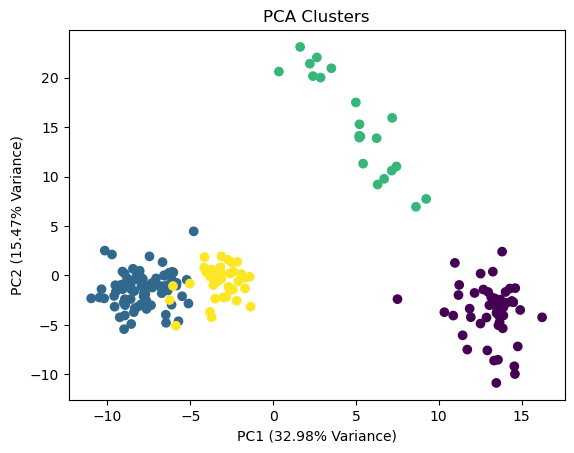

In [57]:
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='viridis')
plt.title("PCA Clusters")
variance_ratio = pca.explained_variance_ratio_
pc1_var = variance_ratio[0] * 100
pc2_var = variance_ratio[1] * 100
plt.xlabel(f"PC1 ({pc1_var:.2f}% Variance)")
plt.ylabel(f"PC2 ({pc2_var:.2f}% Variance)")
plt.show()

In [58]:
# Get clusters
cluster_df["cluster"] = labels

In [38]:
# Create a structural alignment for each cluster

output = "../tmp/struct_align"
os.makedirs(output, exist_ok=True)

cluster = -1
for index, row in cluster_df.sort_values("cluster").iterrows():
    pdb_code = row["PDB code"]
    struct_path = row["structure_path"]
    chain = row["Chain"]
    r1 = row["Position 1\r\n(Bond 1)"]
    r2 = row["Position 2\r\n(catalytic)"]
    r3 = row["Position 3\r\n(Bond 2)"]
    tmp_cluster = row["cluster"]
    pdb_file = pdb.PDBFile.read(struct_path)
    structure = struc.array([atom for atom in pdb_file.get_structure()[0] if atom.hetero==False \
                                and atom.chain_id == chain and atom.element != "H"])
    align_atoms = structure[structure.res_id == r1]
    isopep_bond = structure[(structure.res_id == r1) | (structure.res_id == r2) | (structure.res_id == r3)]
    
    if tmp_cluster != cluster:
        cluster = tmp_cluster
        template_atoms = align_atoms
    
    fitted, transformation = struc.superimpose(template_atoms, align_atoms)
    transf_isopep = transformation.apply(isopep_bond)
    os.makedirs(os.path.join(output, f"cluster_{cluster}"), exist_ok=True)
    struc.io.save_structure(os.path.join(output, f"cluster_{cluster}", f"cluster_{cluster}_{pdb_code}_{chain}_{r1}_{r2}_{r3}.pdb"), transf_isopep)

In [48]:
cluster_df[cluster_df["Isopeptide type"]!="Mutant"].value_counts(["Isopeptide type", "cluster"])\
    .reset_index()\
    .sort_values("Isopeptide type")

,Isopeptide type,cluster,count
1,CnaA-like,0,49
2,CnaA-like,2,21
0,CnaB-like,1,112


<Axes: xlabel='aro-isopep_planes_angle', ylabel='distance_to_aro'>

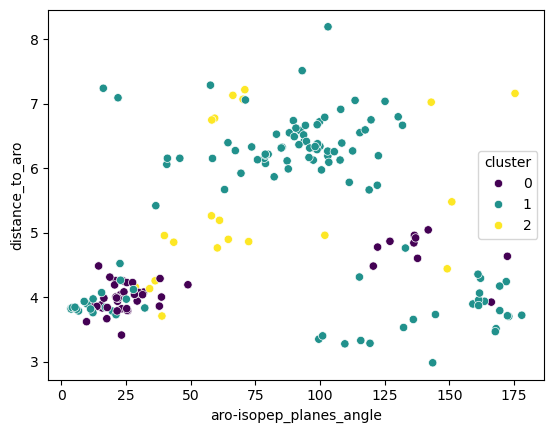

In [49]:
sns.scatterplot(cluster_df, x="aro-isopep_planes_angle", y="distance_to_aro", hue="cluster", palette="viridis")

<Axes: xlabel='o_atom_distance', ylabel='Count'>

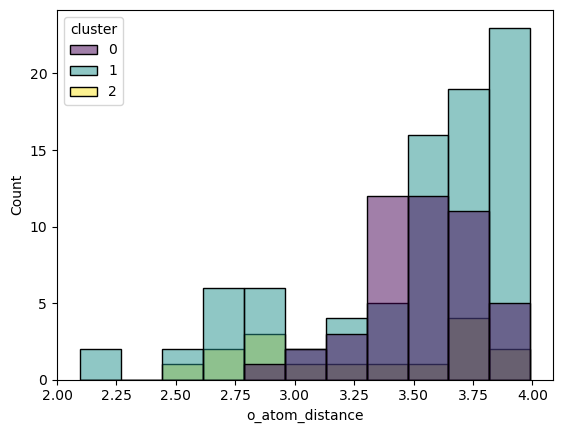

In [50]:
sns.histplot(cluster_df, x="o_atom_distance", hue="cluster", palette="viridis")

<Axes: xlabel='pseudo_psi', ylabel='pseudo_phi'>

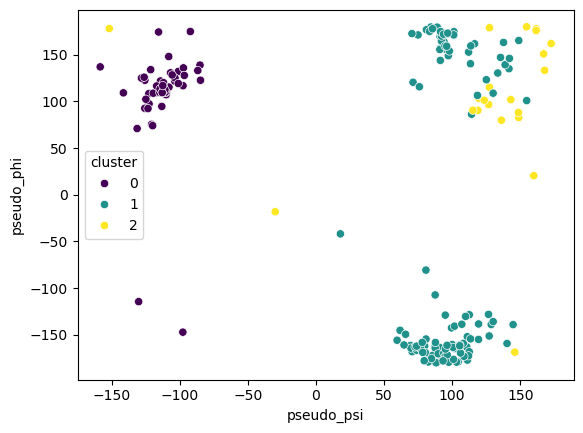

In [51]:
sns.scatterplot(cluster_df, x="pseudo_psi", y="pseudo_phi", hue="cluster", palette="viridis")

<Axes: xlabel='pseudo_psi', ylabel='pseudo_omega'>

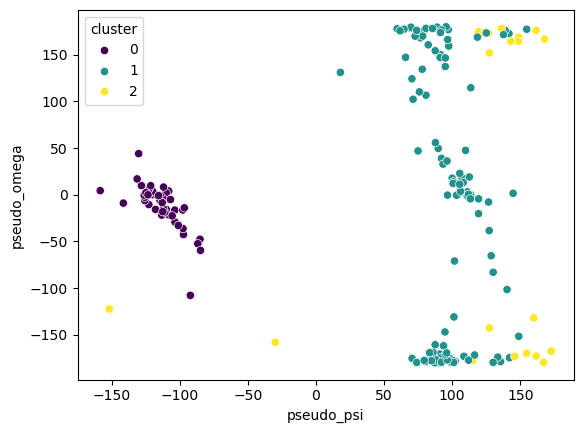

In [52]:
sns.scatterplot(cluster_df, x="pseudo_psi", y="pseudo_omega", hue="cluster", palette="viridis")


<Axes: xlabel='pseudo_phi', ylabel='pseudo_omega'>

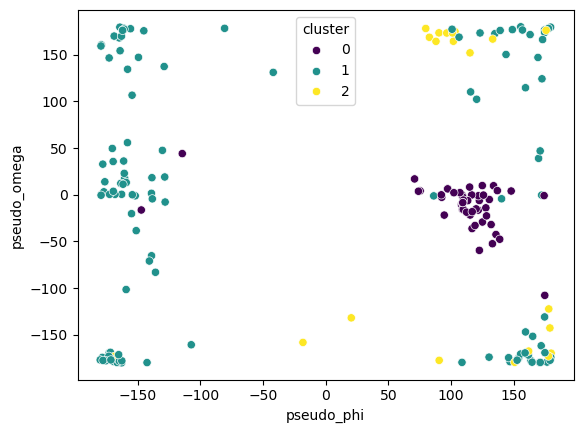

In [53]:
sns.scatterplot(cluster_df, x="pseudo_phi", y="pseudo_omega", hue="cluster", palette="viridis")

In [59]:
# Add cis
cluster_df["cis"] = False
cluster_df.loc[(cluster_df["pseudo_omega"]>=-60)&(cluster_df["pseudo_omega"]<60), "cis"] = True

In [63]:
cond1 = (cluster_df["Isopeptide type"]!="Mutant")
cond2 = (~cluster_df["Residue 2"].isin(["A", "S"]))
cluster_df[cond1&cond2].value_counts(["Isopeptide type", "cluster", "cis"])\
    .reset_index()\
    .sort_values("cluster")

,Isopeptide type,cluster,cis,count
1,CnaA-like,0,True,48
5,CnaA-like,0,False,1
6,CnaB-like,1,True,1
0,CnaB-like,1,False,74
3,CnaA-like,2,False,21
2,CnaB-like,3,True,30
4,CnaB-like,3,False,5


In [64]:
cluster_df[cond1&cond2].value_counts(["Isopeptide type", "cluster", "Residue 1", "Residue 2", "Residue 3"])\
    .reset_index()\
    .sort_values("cluster")

,Isopeptide type,cluster,Residue 1,Residue 2,Residue 3,count
1,CnaA-like,0,K,D,N,49
0,CnaB-like,1,K,E,N,54
6,CnaB-like,1,K,D,N,1
4,CnaB-like,1,K,E,D,20
3,CnaA-like,2,K,D,N,21
2,CnaB-like,3,K,E,N,33
5,CnaB-like,3,K,E,D,2


## Cluster 2

Simply group based on CIS/TRANS and CnaA/B-like 

In [5]:
import shutil

In [15]:
output = "../tmp/struct_align_2"
if os.path.exists(output):
    shutil.rmtree(output)
os.makedirs(output, exist_ok=True)

cond1 = pdb_df["Is bonded"]
cond2 = ~pdb_df["Bad rotamer"]
cond3 = ~pdb_df["Unusual geometry/chemistry"]
cond4 = pdb_df["Isopeptide type"] != "Mutant"
cluster_df = pdb_df[cond1 & cond2 & cond3 & cond4].copy()
# Add cis
cluster_df["cis"] = False
cluster_df.loc[(cluster_df["pseudo_omega"]>=-60)&(cluster_df["pseudo_omega"]<60), "cis"] = True
cluster_df = cluster_df.sort_values(["Isopeptide type", "cis"])

isopeptide_type = None
cis = None

for index, row in cluster_df.iterrows():
    pdb_code = row["PDB code"]
    struct_path = row["structure_path"]
    chain = row["Chain"]
    r1 = row["Position 1\r\n(Bond 1)"]
    r2 = row["Position 2\r\n(catalytic)"]
    r3 = row["Position 3\r\n(Bond 2)"]
    tmp_isopeptide_type = row["Isopeptide type"]
    tmp_cis = row["cis"]

    pdb_file = pdb.PDBFile.read(struct_path)
    structure = struc.array([atom for atom in pdb_file.get_structure()[0] if atom.hetero==False \
                                and atom.chain_id == chain and atom.element != "H"])
    align_atoms = structure[structure.res_id == r1]
    isopep_bond = structure[(structure.res_id == r1) | (structure.res_id == r2) | (structure.res_id == r3)]
    
    if tmp_isopeptide_type != isopeptide_type or tmp_cis != cis:
        isopeptide_type = tmp_isopeptide_type
        cis = tmp_cis
        template_atoms = align_atoms
    
    fitted, transformation = struc.superimpose(template_atoms, align_atoms)
    transf_isopep = transformation.apply(isopep_bond)
    os.makedirs(os.path.join(output, f"{isopeptide_type}_cis_{cis}"), exist_ok=True)
    struc.io.save_structure(os.path.join(output, f"{isopeptide_type}_cis_{cis}", f"{isopeptide_type}_cis_{cis}_{pdb_code}_{chain}_{r1}_{r2}_{r3}.pdb"), transf_isopep)

In [45]:
cond1 = pdb_df["Is bonded"]
cond2 = ~pdb_df["Bad rotamer"]
cond3 = ~pdb_df["Unusual geometry/chemistry"]
cond4 = pdb_df["Isopeptide type"] != "Mutant"
cond5 = pdb_df["Resolution"] <= 2.5
cluster_df = pdb_df[cond1 & cond2 & cond3 & cond4 & cond5].drop_duplicates("isopep_sequence").copy()
# Add cis
cluster_df["cis"] = False
cluster_df.loc[(cluster_df["pseudo_omega"]>=-60)&(cluster_df["pseudo_omega"]<=60), "cis"] = True
cluster_df = cluster_df.sort_values(["Isopeptide type", "cis"])

cluster_df.value_counts(["Isopeptide type", "cis"]).reset_index().sort_values("Isopeptide type")

,Isopeptide type,cis,count
1,CnaA-like,True,33
3,CnaA-like,False,16
0,CnaB-like,False,46
2,CnaB-like,True,17


In [46]:
round(33/(33+16),2)

0.67

In [47]:
round(46/(46+17),2)

0.73

In [48]:
cluster_df.value_counts(["Residue 3", "aro_cap"])

Residue 3  aro_cap
N          True       62
           False      39
D          False      11
Name: count, dtype: int64

In [49]:
cluster_df.value_counts(["aro_cap", "cis"])

aro_cap  cis  
False    False    48
True     True     48
         False    14
False    True      2
Name: count, dtype: int64

In [36]:
48 / 50

0.96

In [39]:
round(14 / (14+48),2)

0.23

In [40]:
cluster_df[(cluster_df["aro_cap"]==True)&(~cluster_df["cis"])]

,PDB code,Chain,UniProt Id,Species,Name,Position 1\r\n(Bond 1),Residue 1,Position 2\r\n(catalytic),Residue 2,Position 3\r\n(Bond 2),...,o_atom_distance,rASA,bond_length,pseudo_omega,pseudo_psi,pseudo_phi,lys_x3,lys_x4,isopep_sequence,cis
35,2x9w,A,A0A0H2UNM7,Streptococcus pneumoniae,RrgB,193,K,241,D,318,...,NaN,"[0.0, 0.020131093227058833, 0.062411770319483084]",1.315928,168.713063,148.898957,82.767385,-169.865944,82.767385,EAKPKIDKDFKGKANPDTPRVDKDTPVNHQVGDVVEYEIVTKIPAL...,False
37,2x9x,A,A0A0H2UNM7,Streptococcus pneumoniae,RrgB,193,K,241,D,318,...,NaN,"[0.0, 0.03368290033808515, 0.06447134162210355]",1.387094,164.370469,148.674640,88.022232,-176.489793,88.022232,AKPKIDKDFKGKANPDTPRVDKDTPVNHQVGDVVEYEIVTKIPALA...,False
54,2xtl,A,B9UQT9,Streptococcus agalactiae,PI-2a backbone protein,199,K,247,D,325,...,NaN,"[0.0, 0.0, 0.002546058718565923]",1.266967,164.475354,143.102162,101.921852,-164.986730,101.921852,ETKPQVDKNFADKELDYANNKKDKGTVSASVGDVKKYHVGTKILKG...,False
61,2y1v,A,A0A0H2UNM7,Streptococcus pneumoniae,RrgB,193,K,241,D,318,...,NaN,"[0.0, 0.03846321040135951, 0.07390627208029389]",1.328575,152.048316,127.347333,115.174557,-169.700913,115.174557,NDVVDAHVYPKNTEAKPKIDKDFKGKANPDTPRVDKDTPVNHQVGD...,False
87,4p0d,A,P18481,Streptococcus pyogenes,tee6,183,K,227,D,309,...,3.125678,"[0.018524130379281394, 0.040758692779424004, 0...",1.255948,-173.046695,145.987630,-168.525506,155.847391,-168.525506,XXNYLYGQTSVAKSSLPSITKKVTGTIDDVNKKTTSLGSVLSYSLT...,False
88,4tsh,B,C9E3B4,Streptococcus mutans,SpaP,1338,K,1387,D,1473,...,3.708350,"[0.256178056321493, 0.004742594767201898, 0.19...",1.296712,-107.706551,-92.182753,174.842775,178.257897,174.842775,FGNGYASNIVINNVPKINPKKDVTXXXXXXXXXXXXXXXXXXXXXX...,False
125,5yu5,A,A0A809N0N0,Lactobacillus rhamnosus,SpaD,186,K,242,D,337,...,3.797223,"[0.04419032291668217, 0.0, 0.01916997485859379]",1.254912,174.889958,119.608633,103.225489,-168.612495,103.225489,QDXXXDLTNIHLYPKDSLVTKNLTEINEQAVATKDLHDVAVGDVLT...,False
128,5yxg,A,A0A809N0N0,Lactobacillus rhamnosus,SpaD,186,K,242,D,337,...,3.906000,"[0.05293700404283477, 0.0, 0.10789490923000748]",1.334115,173.304275,126.762218,96.632581,-167.342066,96.632581,VTKNLTEINEQAVATKDLHDVAVGDVLTYQVQFQIPHDIGALAXXX...,False
21,3hr6,A,Q6NF81,Corynebacterium diphtheriae,SpaA,363,K,446,E,482,...,3.494109,"[0.0292486260576946, 0.03861974686691441, 0.0]",1.315230,179.967944,95.584522,155.641979,61.271619,155.641979,ALRGMPSSRVSSKFGQITIEKSFDGNTPGADRTATFQLHRCEADGS...,False
53,2xtl,A,B9UQT9,Streptococcus agalactiae,PI-2a backbone protein,355,K,416,D,437,...,NaN,"[0.011356713132160466, 0.008241880800306182, 0.0]",1.579295,-170.563074,90.973359,155.553911,75.967160,155.553911,PTIENEPKEGIPVDKKITVNKTWAVDGNEVNKADETVDAVFTLQVK...,False


## Proximal oxygen

In [35]:
cond1 = pdb_df["Is bonded"]
cond2 = ~pdb_df["Bad rotamer"]
cond3 = ~pdb_df["Unusual geometry/chemistry"]
cond4 = pdb_df["Isopeptide type"] != "Mutant"
cond5 = pdb_df["Resolution"] <= 2.5

o_df = pdb_df[cond1 & cond2 & cond3 & cond4 & cond5] \
        .drop_duplicates("isopep_sequence").copy()

o_df["water_od"] = False
o_df.loc[o_df["water_distance_OD"] <= 5, "water_od"] = True

o_df["any_ox"] = False
o_df.loc[o_df["o_atom_distance"] <= 5, "any_ox"] = True

In [41]:
o_df[o_df["Isopeptide type"]=="CnaA-like"].value_counts("water_od", normalize=True).round(2)

water_od
True     0.69
False    0.31
Name: proportion, dtype: float64

In [28]:
o_df[o_df["Isopeptide type"]=="CnaB-like"].value_counts("water_od", normalize=True).round(2)

water_od
True     0.55
False    0.45
Name: proportion, dtype: float64

In [26]:
# correlation with aro cap
o_df.groupby("aro_cap")["water_od"] \
    .value_counts(normalize=True) \
    .mul(100) \
    .rename("percentage") \
    .reset_index().round()

,aro_cap,water_od,percentage
0,False,True,61.0
1,False,False,39.0
2,True,True,61.0
3,True,False,39.0


In [29]:
o_df[o_df["Isopeptide type"]=="CnaB-like"].groupby("aro_cap")["water_od"] \
    .value_counts(normalize=True) \
    .mul(100) \
    .rename("percentage") \
    .reset_index().round()

,aro_cap,water_od,percentage
0,False,True,56.0
1,False,False,44.0
2,True,True,53.0
3,True,False,47.0


In [30]:
o_df[o_df["Isopeptide type"]=="CnaA-like"].groupby("aro_cap")["water_od"] \
    .value_counts(normalize=True) \
    .mul(100) \
    .rename("percentage") \
    .reset_index().round()

,aro_cap,water_od,percentage
0,False,True,68.0
1,False,False,32.0
2,True,True,69.0
3,True,False,31.0


In [31]:
o_df.value_counts(["Residue 3", "water_od"])

Residue 3  water_od
N          True        47
           False       28
D          False        5
           True         4
Name: count, dtype: int64

In [36]:
o_df[o_df["Isopeptide type"]=="CnaB-like"].value_counts("any_ox", normalize=True).round(2)

any_ox
True    1.0
Name: proportion, dtype: float64

In [37]:
o_df[o_df["Isopeptide type"]=="CnaA-like"].value_counts("any_ox", normalize=True).round(2)

any_ox
True    1.0
Name: proportion, dtype: float64

In [38]:
o_df.value_counts(["Residue 3", "water_od"])

Residue 3  water_od
N          True        47
           False       28
D          False        5
           True         4
Name: count, dtype: int64

In [39]:
o_df.value_counts(["Residue 2"])

Residue 2
E            48
D            36
Name: count, dtype: int64